# Testing Navier-Stokes with a body in package `Whirl`

In [1]:
include(joinpath(Pkg.dir("Whirl"), "src/Whirl.jl"))
using Whirl

In [3]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

### Solve flow past an elliptical body

Set the flow parameters

In [4]:
Re = 200; # Reynolds number
U = 1.0; # Free stream velocity
U∞ = (U,0.0);

Set up points on the ellipse

In [5]:
n = 50;
a = 0.5; b = 0.1;
body = Bodies.Plate(1.0,n)

Plate with 50 points and length 1.0 and thickness 0.0
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


Set the body motion. For now, make it stationary.

In [6]:
motion = RigidBodyMotion(0.0,0.0)

Rigid Body Motion:
  ċ = 0.0 + 0.0im
  c̈ = 0.0 + 0.0im
  α̇ = 0.0
  α̈ = 0.0
  Constant (ċ = 0.0 + 0.0im, α̇ = 0.0)

Transform the body with a specified initial position and orientation.

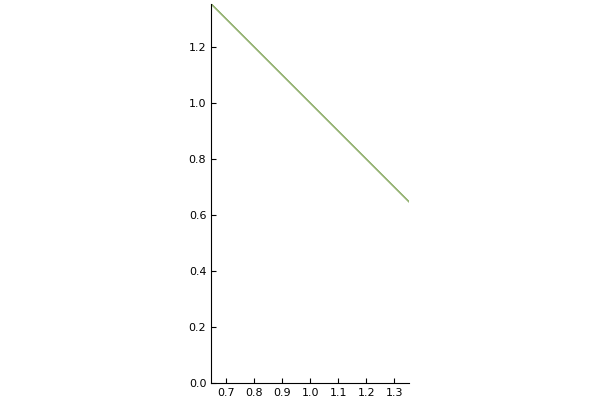

In [7]:
cent = 1.0+1.0im
α = -π/4
_,ċ,_,_,α̇,_ = motion(0.0)  # Additional 
T = RigidTransform(cent,α)
T(body) # transform the body to the current configuration
ds = Bodies.dlength(body) # we will need the arc lengths of each face on the body for later
plot(body)

Now set up the coordinate data for operator construction

In [8]:
X = VectorData(body.x,body.y)
f = VectorData(X);

Set the domain size and time step size

In [9]:
nx = 202; ny = 102;
Lx = 2.0;
Δx = Lx/(ny-2);
Δt = min(0.5*Δx,0.5*Δx^2*Re);
w₀ = Nodes(Dual,(nx,ny));
q = Edges(Primal,w₀);

Construct the 'system'

In [10]:
sys = Systems.NavierStokes((nx,ny),Re,Δx,Δt,U∞ = U∞)

Navier-Stokes system on a grid of size 202 x 102

### Now start constructing operators

First, the regularization operators

In [11]:
regop = Regularize(X,Δx;issymmetric=true)
Hmat, Emat = RegularizationMatrix(regop,f,q);

In [12]:
B₂(w::Nodes) = -(Emat*(Curl()*(sys.L\w)))

B₂ (generic function with 1 method)

In [13]:
B₁ᵀ(f::VectorData) = Curl()*(Hmat*f)

B₁ᵀ (generic function with 1 method)

In [14]:
function r₂(w::Nodes{T,NX,NY},t::Float64) where {T,NX,NY}
    f = VectorData(X)
    for i = 1:length(body)
        _,ċi,_ = motion(t,(body.x[i],body.y[i]))
        f.u[i] = real(ċi)
        f.v[i] = imag(ċi)    
    end
    f.u .-= U∞[1]
    f.v .-= U∞[2]
    return f
end

r₂ (generic function with 1 method)

In [15]:
ifherk = IFHERK(w₀,f,sys.Δt,
                (t,w) -> Systems.plan_intfact(t,w,sys),
                (B₁ᵀ, B₂),
                ((w,t) -> Systems.r₁(w,t,sys),
                 (w,t) -> r₂(w,t)),rk=TimeMarching.RK31,store=true)

Order-3 IF-HERK integrator with
   State of type Whirl.Fields.Nodes{Whirl.Fields.Dual,202,102}
   Force of type Whirl.Fields.VectorData{51}
   Time step size 0.01


In [16]:
t = 0.0
w₀ .= 0.0
w = deepcopy(w₀)
tf = 4
T = 0:Δt:tf;
fx = Float64[];
fy = Float64[];
thist = Float64[];

In [20]:
@time for ti in T
    t, w, f = ifherk(t,w)
    push!(thist,t)
    push!(fx,sum(f.u)*Δx^2)
    push!(fy,sum(f.v)*Δx^2)
end
println(t)

 29.171147 seconds (9.51 M allocations: 4.336 GiB, 3.30% gc time)
8.019999999999873


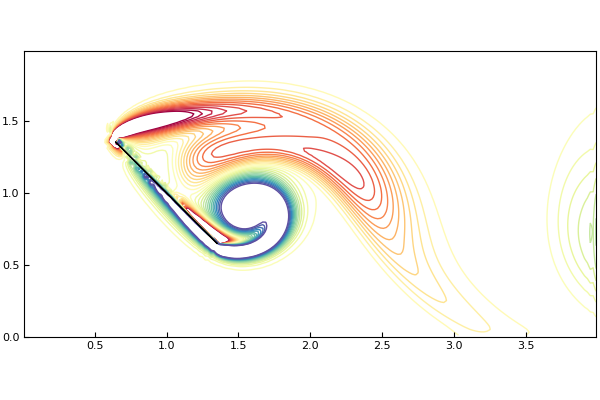

In [25]:
xg,yg = coordinates(w,dx=Δx)
plot(xg,yg,w,trim=1,levels=linspace(-0.15,0.15,30))
plot!(body,fillcolor=:black,linecolor=:black)

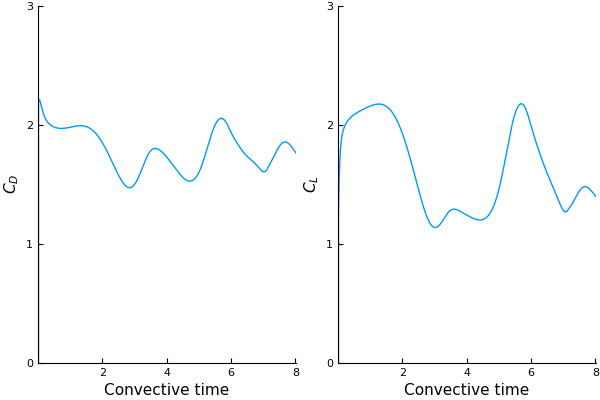

In [26]:
px = plot(thist,2*fx,ylim=(0,3),xlabel="Convective time",ylabel="\$C_D\$",legend=false)
py = plot(thist,2*fy,ylim=(0,3),xlabel="Convective time",ylabel="\$C_L\$",legend=false)
plot(px,py)

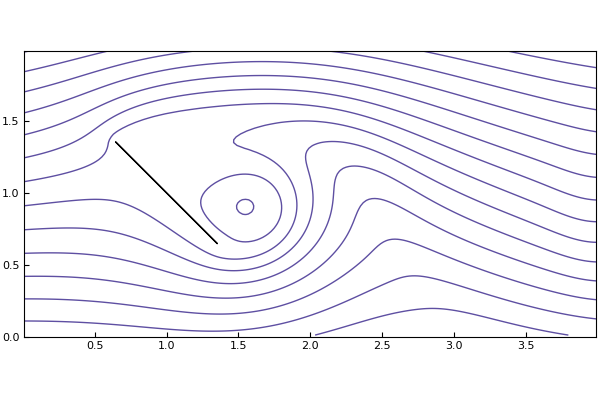

In [28]:
xg,yg = coordinates(w,dx=Δx)
ψ = deepcopy(w)
ψ .= -(sys.L\w)*Δx .+ repmat(collect(yg)',202,1)
plot(xg,yg,ψ,trim=1,clim=(-0.1,0.1))
plot!(body,fillcolor=:black,linecolor=:black)

In [5]:
regopfilter = Regularize(X,Δx;weights=ds,filter=true)
H̃mat = RegularizationMatrix(regopfilter,f,q);
Ẽmat = InterpolationMatrix(regopfilter,q,f);
P(f::VectorData) = Ẽmat*(H̃mat*f)